In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


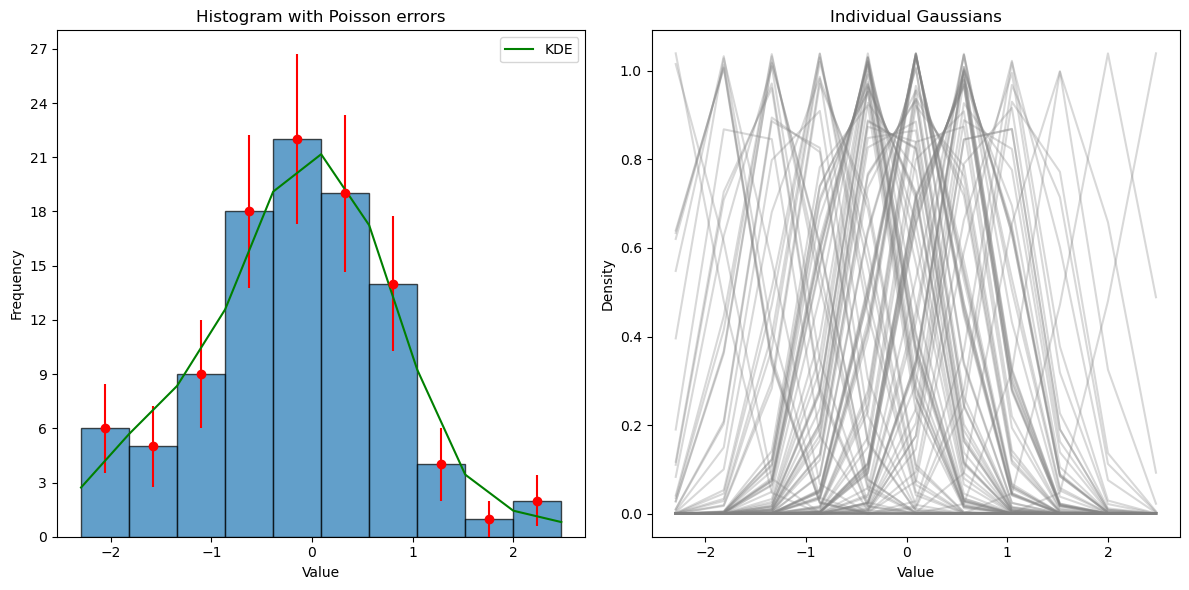

In [8]:
#1
N = 100 #size of dataset
mean = 0 #mean of the distribution
std = 1 #stdev of the distribution
x = np.random.normal(mean, std, N) #array di N valori random con media e stdev
#print(x)
#2
n_bins = int(np.sqrt(N)) #il numero di colonne in questo caso è 10, una scelta comune per i bins
fig, axes = plt.subplots(1,2,figsize=(12,6)) #l'istogramma sarà descritto dall'oggetto axes[0]
counts, bins, patches = axes[0].hist(x, bins=n_bins, alpha=0.7, edgecolor='black')
#counts sono i dati in x, bins le colonne e patches le ulteriori cose per costumizzazione
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram with Poisson errors')
axes[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True)) #prende la locazione del massimo della y
bin_centers = 0.5 * (bins[1:] + bins[:-1]) #1/2 * la distanza tra l'inizio del bin e la fine
poisson_errors = np.sqrt(counts) #definizione di errore di Poisson
axes[0].errorbar(bin_centers, counts, yerr=poisson_errors, fmt='o', color='red') #fmt='o' errori cerchi
#3
std_kde = 1.06 * x.std() * N**(-1/5) #nuova std con kde
gaussians = [stats.norm(xi, std_kde).pdf(bins) for xi in x] #lista gaussiane
#4
for gaussian in gaussians:
    axes[1].plot(bins, gaussian, color='grey', alpha=0.3)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].set_title('Individual Gaussians')
plt.tight_layout()
#5
summed_gaussians = np.sum(gaussians, axis=0) #sommo tutte le gaussiane
area_histogram = np.sum(np.diff(bins) * counts)
area_kde = scipy.integrate.trapz(summed_gaussians, bins)
normalized_kde = summed_gaussians * (area_histogram / area_kde)
axes[0].plot(bins, normalized_kde, label='KDE', color='green')
axes[0].legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

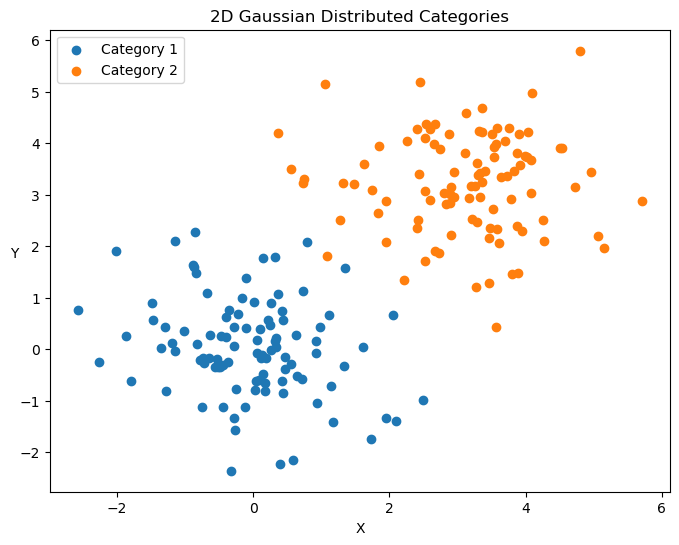

In [3]:
#1 
def generate_gaussian_dataset(categories, points, means, stds):
    data = [] #apro la lista per i dati
    labels = [] #apro la lista per le labels
    for i in range(categories): #itera per ogni categoria
        category_data = np.random.normal(means[i], stds[i], (points, 2)) #prende la media e la std
        #della i-esima categoria e crea un array con dimensioni points x 2
        data.append(category_data) #inserisce l'array nella lista dei dati
        labels.append(np.full(points, i)) #crep un array di lunghezza points riempito con l'indice i
        #e lo mette in labels. assegna un'etichetta ad ogni punto della categoria
    data = np.vstack(data) #impila gli array verticalmente
    labels = np.concatenate(labels) #unisce le labels nell'asse orizzontale
    return(data, labels) #mi ritorna praticamente una matrice con labels e dati per categoria

num_categories = 2
points_per_category = 100
means = [(0,0), (3,3)]
std_devs = [(1,1), (1,1)]
data, labels = generate_gaussian_dataset(num_categories, points_per_category, means, std_devs)

plt.figure(figsize=(8,6))
for i in range(num_categories):
    plt.scatter(data[labels == i,0], data[labels == i,1], label=f'Category {i+1}')
plt.title("2D Gaussian Distributed Categories")
plt.xlabel("X")
plt.ylabel("Y", rotation='horizontal')
plt.legend()
plt.show()

In [ ]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

   residuals  distances
0       1.10       16.0
1      -1.95        6.3
2      -7.20        3.4
3      -4.15        8.4
4      -6.59        1.7


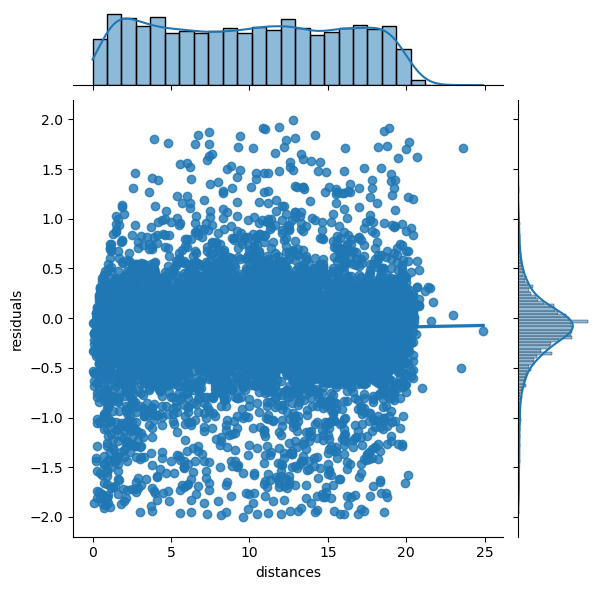

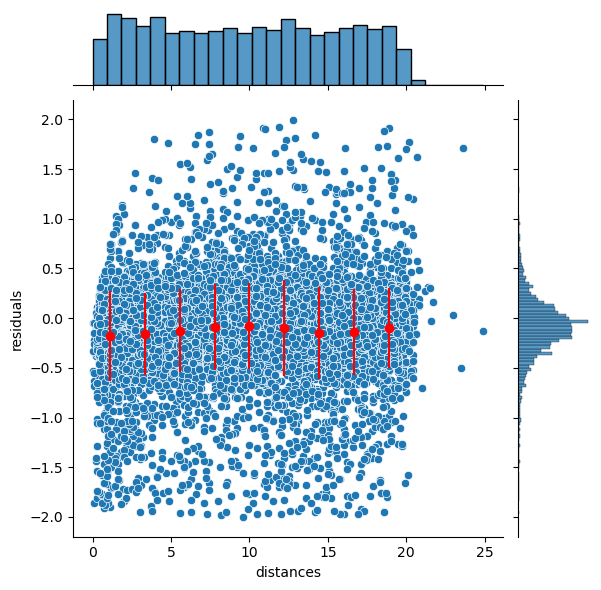

In [12]:
#1
data = np.load('residuals_261.npy', allow_pickle=True).item()
df = pd.DataFrame(data)
print(df.head())
#2
df_cleaned = df[df['residuals'].abs() < 2]
#3
slope, intercept, r_value, p_value, std_err = stats.linregress(df_cleaned['distances'], df_cleaned['residuals'])
#4
sns.jointplot(x='distances', y='residuals', data=df_cleaned, kind='reg')
plt.show()
#5
n_bins = 10
bins = np.linspace(0, 20, n_bins)
x = 0.5 * (bins[:-1] + bins[1:])
y = [df_cleaned[(df_cleaned['distances'] >= bins[i]) & 
                (df_cleaned['distances'] < bins[i+1])]['residuals'].mean() for i in range(n_bins-1)]
erry = [df_cleaned[(df_cleaned['distances'] >= bins[i]) & 
                   (df_cleaned['distances'] < bins[i+1])]['residuals'].std() for i in range(n_bins-1)]
#6
sns.jointplot(x='distances', y='residuals', data=df_cleaned, kind='scatter')
plt.errorbar(x, y, yerr=erry, fmt='o', color='red') 
plt.show()
